In [19]:
# Import modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import math
import optuna

In [20]:
def set_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        print(f'Using device: {device}')
        print(f'GPU: {torch.cuda.get_device_name(0)}')
    else:
        print(f'Using device: {device}')

    return device

In [21]:
def norm_data(name):
    df = pd.read_csv(name)
    ndf = pd.DataFrame()
    range_mm={
        'V': {'min':df['V'].min()*0.8, 'max': df['V'].max()*1.2},
        'E': {'min':df['E'].min()*0.8, 'max': df['E'].max()*1.2},
        'VF': {'min':df['VF'].min()*0.8, 'max': df['VF'].max()*1.2},
        'VA': {'min':df['VA'].min()*0.8, 'max': df['VA'].max()*1.2},
        'VB': {'min':df['VB'].min()*0.8, 'max': df['VB'].max()*1.2},
        'CFLA': {'min':0, 'max': df['CFLA'].max()*1.2},
        'CALA': {'min':0, 'max': df['CALA'].max()*1.2},
        'CBLA': {'min':0, 'max': df['CBLA'].max()*1.2},
        'CFK': {'min':0, 'max': df['CFK'].max()*1.2},
        'CAK': {'min':0, 'max': df['CAK'].max()*1.2},
        'CBK': {'min':0, 'max': df['CBK'].max()*1.2},
        'I': {'min':0, 'max': df['I'].max()*1.2},
    }

    ndf['exp'] = df['exp']; ndf['t'] = df['t']

    for col in ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CBLA', 'CFK', 'CAK', 'CBK', 'I']:
        if col in range_mm:
            ndf[col] = (df[col] - range_mm[col]['min'])/(range_mm[col]['max'] - range_mm[col]['min'])
        else:
            ndf[col] = df[col]
    return ndf

In [22]:
def seq_data_const(ndf):
    sequences = []
    feature_cols = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CBLA', 'CFK', 'CAK', 'CBK', 'I']
    
    for exp in ndf['exp'].unique():
        exp_data = ndf[ndf['exp'] == exp].sort_values(by='t')
        sequences.append(exp_data[feature_cols].values)
    
    return sequences

In [23]:
def padded_sequences(sequences):
    max_seq_len = max([len(seq) for seq in sequences])
    seq_len = [len(seq) for seq in sequences]
    padded_sequences = pad_sequence([torch.tensor(seq) for seq in sequences], batch_first=True, padding_value=-1)

    return padded_sequences, seq_len, max_seq_len

In [24]:
def gen_dataset(pad_seq, seq_len):
    input_tensor = pad_seq.float()
    seq_len_tensor = torch.tensor(seq_len)
    dataset = TensorDataset(input_tensor, seq_len_tensor)
    return dataset

In [25]:
def kfold_dataloaders(dataset, k_folds=5, batch_size=8, random_state=42):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    dataloaders = []
    batch_size = math.ceil(len(dataset)/k_folds)
    
    for fold, (train_indices, val_indices) in enumerate(kfold.split(range(len(dataset)))):
        print(f"Fold {fold + 1}: Train size = {len(train_indices)}, Val size = {len(val_indices)}")
        
        # Create subsets for train and validation
        train_subset = Subset(dataset, train_indices)
        val_subset = Subset(dataset, val_indices)
        
        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        dataloaders.append((train_loader, val_loader))
    return dataloaders

In [26]:
class SequentialStateExtractor(nn.Module):
    """
    BMED 시스템의 시계열 패턴에서 숨겨진 dynamics를 추출하는 LSTM 기반 모듈
    각 시점의 hidden state에는 해당 시점까지의 모든 과거 정보가 누적됨
    """
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer with improved error handling
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, 
            batch_first=True, dropout=dropout if num_layers > 1 else 0
        )
        
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        """
        시계열 상태 시퀀스를 처리하여 각 시점의 hidden state 추출
        
        Args:
            x: [batch_size, seq_len, input_size] - BMED 시스템 상태 시퀀스
            seq_len: [batch_size] - 각 시퀀스의 실제 길이
            
        Returns:
            hidden_states: [batch_size, seq_len, hidden_size] - 각 시점의 누적된 hidden state
        """
        
        # 입력 검증
        if x.size(0) != seq_len.size(0):
            raise ValueError(f"Batch size mismatch: input {x.size(0)} vs seq_len {seq_len.size(0)}")
        
        # seq_len을 CPU로 이동하고 정수형으로 변환
        seq_len_cpu = seq_len.detach().cpu().long()
        
        # 시퀀스 길이 유효성 검사
        if (seq_len_cpu <= 0).any():
            invalid_lengths = seq_len_cpu[seq_len_cpu <= 0]
            raise ValueError(f"Invalid sequence lengths detected: {invalid_lengths.tolist()}. All sequence lengths must be positive.")
        
        # 패딩된 시퀀스를 pack하여 효율적 처리
        packed_input = pack_padded_sequence(
            x, seq_len_cpu, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_input)
        
        # 다시 패딩된 형태로 복원
        lstm_out, output_lengths = pad_packed_sequence(
            packed_output, batch_first=True, total_length=x.size(1)
        )
        
        # Normalization and dropout
        normalized = self.layer_norm(lstm_out)
        return self.dropout(normalized)

In [27]:
class PhysicalChangeDecoder(nn.Module):
    """
    Hidden state로부터 BMED 시스템의 물리적 변화량과 새로운 전류값을 디코딩하는 MLP
    출력: [dVA, dVB, dNALA, dNBLA, dNAK, dNBK, nI] - 7개 물리적 변화량
    """
    def __init__(self, hidden_size, output_size, num_layers=2, num_nodes=None, dropout=0.3):
        super().__init__()

        if num_nodes is None:
            num_nodes = hidden_size
        
        self.layers = nn.ModuleList()

        # 첫 번째 레이어: hidden_size → num_nodes
        self.layers.append(nn.Linear(hidden_size, num_nodes))
        self.layers.append(nn.LayerNorm(num_nodes))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        # 중간 은닉층들: num_nodes → num_nodes
        for i in range(num_layers - 1):
            self.layers.append(nn.Linear(num_nodes, num_nodes))
            self.layers.append(nn.LayerNorm(num_nodes))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        # 마지막 출력층: num_nodes → output_size (7개 물리적 변화량)
        self.layers.append(nn.Linear(num_nodes, output_size))

    def forward(self, hidden_states):
        """
        Hidden state를 물리적 변화량으로 디코딩
        
        Args:
            hidden_states: [batch_size, seq_len, hidden_size] - 시점별 hidden state
            
        Returns:
            physical_changes: [batch_size, seq_len, 7] - 물리적 변화량
                [dVA, dVB, dNALA, dNBLA, dNAK, dNBK, nI]
        """
        x = hidden_states
        for layer in self.layers:
            x = layer(x)
        return x

In [28]:
class PhysicsConstraintLayer(nn.Module):
    """
    물리적 변화량을 실제 시스템 상태로 변환하면서 물리적 제약 조건을 적용
    Bipolar membrane electrodialysis 시스템의 물리 법칙 기반 상태 업데이트
    """
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps  # division by zero 방지
        
    def forward(self, physical_changes, current_state):
        """
        물리적 변화량을 현재 상태에 적용하여 다음 상태 계산
        
        Args:
            physical_changes: [batch, seq, 7] - [dVA, dVB, dNALA, dNBLA, dNAK, dNBK, nI]
            current_state: [batch, seq, 12] - 현재 BMED 시스템 상태
                V: 전압 (Voltage) - 실험 세트별 고정값
                E: 외부 전해질 농도 (External electrolyte concentration) - 실험 세트별 고정값  
                VF, VA, VB: Feed, Acid, Base 부피
                CFLA, CALA, CBLA: Feed, Acid, Base의 LA 농도
                CFK, CAK, CBK: Feed, Acid, Base의 K 농도
                I: 전류
                
        Returns:
            next_state: [batch, seq, 12] - 물리 제약이 적용된 다음 상태
        """
        # 입력 차원 검증
        if physical_changes.dim() != current_state.dim():
            raise ValueError(f"Dimension mismatch: physical_changes {physical_changes.shape} vs current_state {current_state.shape}")
        
        if current_state.size(-1) != 12:
            raise ValueError(f"Expected 12 state features, got {current_state.size(-1)}")
            
        if physical_changes.size(-1) != 7:
            raise ValueError(f"Expected 7 physical changes, got {physical_changes.size(-1)}")
        
        # 현재 상태 변수 추출 (차원 유지)
        V = current_state[..., 0:1]     # 전압 (고정값)
        E = current_state[..., 1:2]     # 외부 전해질 농도 (고정값)
        VF = current_state[..., 2:3]    # Feed 부피
        VA = current_state[..., 3:4]    # Acid 부피
        VB = current_state[..., 4:5]    # Base 부피
        CFLA = current_state[..., 5:6]  # Feed LA 농도
        CALA = current_state[..., 6:7]  # Acid LA 농도
        CBLA = current_state[..., 7:8]  # Base LA 농도
        CFK = current_state[..., 8:9]   # Feed K 농도
        CAK = current_state[..., 9:10]  # Acid K 농도
        CBK = current_state[..., 10:11] # Base K 농도
        I = current_state[..., 11:12]   # 전류

        # 물질량 계산 (농도 × 부피)
        NFLA = CFLA * VF; NALA = CALA * VA; NBLA = CBLA * VB
        NFK = CFK * VF; NAK = CAK * VA; NBK = CBK * VB

        # 물리적 변화량 추출
        dVA = physical_changes[..., 0:1]    # Acid 부피 변화량 (양방향 가능: 음수면 A→F)
        dVB = physical_changes[..., 1:2]    # Base 부피 변화량 (양방향 가능: 음수면 B→F)
        dNALA = physical_changes[..., 2:3]  # Acid LA 물질량 변화량 (일방향: F→A만)
        dNBLA = physical_changes[..., 3:4]  # Base LA 물질량 변화량 (일방향: F→B만)
        dNAK = physical_changes[..., 4:5]   # Acid K 물질량 변화량 (일방향: F→A만)
        dNBK = physical_changes[..., 5:6]   # Base K 물질량 변화량 (일방향: F→B만)
        nI = physical_changes[..., 6:7]     # 새로운 전류값

        # 새로운 부피 계산 (양방향 흐름 허용)
        nVF = VF - dVA - dVB  # dVA, dVB가 음수면 F로 역유입
        nVA = VA + dVA        # dVA가 음수면 A에서 F로 유출
        nVB = VB + dVB        # dVB가 음수면 B에서 F로 유출
        
        # 물질 이동량을 일방향으로 제한 (F→A, F→B만 허용)
        dNALA_clipped = torch.clamp(dNALA, min=0)  # 음수 제거 (역방향 불가)
        dNBLA_clipped = torch.clamp(dNBLA, min=0)
        dNAK_clipped = torch.clamp(dNAK, min=0)
        dNBK_clipped = torch.clamp(dNBK, min=0)
        
        # 새로운 물질량 계산 (일방향 이동만)
        nNFLA = NFLA - dNALA_clipped - dNBLA_clipped  # Feed에서 유출만
        nNALA = NALA + dNALA_clipped                  # Acid로 유입만
        nNBLA = NBLA + dNBLA_clipped                  # Base로 유입만
        nNFK = NFK - dNAK_clipped - dNBK_clipped      # K도 마찬가지
        nNAK = NAK + dNAK_clipped
        nNBK = NBK + dNBK_clipped
        
        # 물리적 제약 조건 적용 (양수 유지)
        nVF = torch.clamp(nVF, min=self.eps)
        nVA = torch.clamp(nVA, min=self.eps)
        nVB = torch.clamp(nVB, min=self.eps)
        
        # 물질량 음수 방지
        nNFLA = torch.clamp(nNFLA, min=0)
        nNALA = torch.clamp(nNALA, min=0)
        nNBLA = torch.clamp(nNBLA, min=0)
        nNFK = torch.clamp(nNFK, min=0)
        nNAK = torch.clamp(nNAK, min=0)
        nNBK = torch.clamp(nNBK, min=0)
        
        # 새로운 농도 계산 (농도 = 물질량 / 부피)
        nCFLA = nNFLA / nVF
        nCALA = nNALA / nVA
        nCBLA = nNBLA / nVB
        nCFK = nNFK / nVF
        nCAK = nNAK / nVA
        nCBK = nNBK / nVB
        
        # 전류는 양수 제약
        nI = torch.clamp(nI, min=0)

        # 새로운 상태 조립 (V, E는 고정값이므로 그대로 유지)
        next_state = torch.cat([
            V, E,  # 고정값: 전압, 외부 전해질 농도
            nVF, nVA, nVB,  # 새로운 부피 (양방향 흐름 반영)
            nCFLA, nCALA, nCBLA,  # 새로운 LA 농도
            nCFK, nCAK, nCBK,     # 새로운 K 농도
            nI  # 새로운 전류
        ], dim=-1)
        
        return next_state

In [29]:
class BMEDAutoregressiveModel(nn.Module):
    """
    BMED 시스템의 시계열 상태 예측을 위한 자기회귀 모델
    
    구조:
    1. SequentialStateExtractor: LSTM으로 시계열 패턴의 hidden state 추출
    2. PhysicalChangeDecoder: Hidden state를 물리적 변화량으로 디코딩  
    3. PhysicsConstraintLayer: 물리 법칙 적용하여 다음 상태 계산
    """
    def __init__(self, state_extractor_params, decoder_params):
        super().__init__()
        self.state_extractor = SequentialStateExtractor(**state_extractor_params)
        self.physical_decoder = PhysicalChangeDecoder(**decoder_params)
        self.physics_constraint = PhysicsConstraintLayer()

    def forward(self, current_states, seq_lengths):
        """
        현재 시점까지의 상태들로부터 다음 상태들 예측
        
        Args:
            current_states: [batch, seq_len, 12] - 현재까지의 BMED 시스템 상태들
            seq_lengths: [batch] - 각 시퀀스의 실제 길이
            
        Returns:
            next_states: [batch, seq_len, 12] - 예측된 다음 시점 상태들
        """
        # 1. LSTM으로 각 시점의 hidden state 추출 (과거 정보 누적)
        hidden_states = self.state_extractor(current_states, seq_lengths)
        
        # 2. Hidden state를 물리적 변화량으로 디코딩
        physical_changes = self.physical_decoder(hidden_states)
        
        # 3. 물리적 제약 조건을 적용하여 다음 상태 계산
        next_states = self.physics_constraint(physical_changes, current_states)
        
        return next_states

In [30]:
def masked_mse_loss(predictions, targets, seq_lengths):
    """
    개선된 마스킹된 MSE 손실 함수 - device 호환성 및 안정성 강화
    
    Args:
        predictions: 모델 예측값 [batch_size, seq_len, features]
        targets: 실제 타겟값 [batch_size, seq_len, features]  
        seq_lengths: 각 시퀀스의 실제 길이 [batch_size]
    
    Returns:
        masked_loss: 패딩 부분을 제외한 평균 MSE 손실
    """
    # 입력 검증
    if predictions.shape != targets.shape:
        raise ValueError(f"Shape mismatch: predictions {predictions.shape} vs targets {targets.shape}")
    
    if predictions.size(0) != seq_lengths.size(0):
        raise ValueError(f"Batch size mismatch: predictions {predictions.size(0)} vs seq_lengths {seq_lengths.size(0)}")
    
    batch_size, max_len, features = predictions.shape
    
    # seq_lengths를 CPU로 이동하여 arange와 호환되도록 처리
    seq_lengths_cpu = seq_lengths.detach().cpu().long()
    
    # 시퀀스 길이 유효성 검사 - 데이터 구조 오류는 중단해야 함
    if (seq_lengths_cpu <= 0).any():
        invalid_lengths = seq_lengths_cpu[seq_lengths_cpu <= 0]
        raise ValueError(f"Invalid sequence lengths detected: {invalid_lengths.tolist()}. All sequence lengths must be positive.")
    
    # 최대 길이 초과 검사
    if (seq_lengths_cpu > max_len).any():
        invalid_lengths = seq_lengths_cpu[seq_lengths_cpu > max_len]
        raise ValueError(f"Sequence lengths exceed max_len: {invalid_lengths.tolist()} > {max_len}")
    
    # 마스크 생성: 실제 시퀀스 길이만큼만 True
    mask = torch.arange(max_len, device='cpu')[None, :] < seq_lengths_cpu[:, None]
    mask = mask.float().to(predictions.device)
    
    # 각 요소별 MSE 계산 (reduction='none')
    loss = F.mse_loss(predictions, targets, reduction='none')
    
    # 마스크 적용하여 패딩 부분 제거
    masked_loss_sum = (loss * mask.unsqueeze(-1)).sum()
    valid_elements = mask.sum() * features
    
    # 0으로 나누기 방지
    if valid_elements == 0:
        raise ValueError("No valid elements found after masking. Check sequence lengths and data.")
    
    masked_loss = masked_loss_sum / valid_elements
    
    return masked_loss

In [31]:
def prepare_teacher_forcing_data(input_sequences, seq_lengths):
    """
    Teacher Forcing을 위한 입력-타겟 데이터 준비
    
    Args:
        input_sequences: 전체 시퀀스 [batch_size, seq_len, features]
        seq_lengths: 각 시퀀스의 실제 길이 [batch_size]
    
    Returns:
        inputs: [t0, t1, ..., t_{n-1}] 현재 상태들
        targets: [t1, t2, ..., t_n] 다음 상태들  
        target_seq_lengths: 타겟 시퀀스 길이 (1씩 감소)
    """
    # 입력: 마지막 시점 제외 [:-1]
    inputs = input_sequences[:, :-1, :]
    
    # 타겟: 첫 번째 시점 제외 [1:]  
    targets = input_sequences[:, 1:, :]
    
    # **타겟 시퀀스 길이는 1씩 감소 (마지막 시점 예측 불가)**
    if (seq_lengths - 1 < 1).any():
        invalid_lengths = seq_lengths[seq_lengths - 1 < 1]
        raise ValueError(f"타겟 시퀀스 길이가 0보다 작아질 수 없습니다. 잘못된 seq_lengths: {invalid_lengths.tolist()}")
    target_seq_lengths = seq_lengths - 1
    
    return inputs, targets, target_seq_lengths

In [32]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    epoch_loss = 0.0
    
    for batch_idx, (input_seq, seq_lengths) in enumerate(train_loader):
        # 데이터를 디바이스로 이동
        input_seq = input_seq.to(device)
        seq_lengths = seq_lengths.to(device)
        
        # Teacher Forcing 데이터 준비
        inputs, targets, target_seq_lengths = prepare_teacher_forcing_data(input_seq, seq_lengths)
        
        # Forward pass
        predictions = model(inputs, target_seq_lengths)
        
        # Loss 계산 (마스크 적용)
        loss = masked_mse_loss(predictions, targets, target_seq_lengths)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(train_loader)

def validate_epoch(model, val_loader, device):
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for input_seq, seq_lengths in val_loader:
            # 데이터를 디바이스로 이동
            input_seq = input_seq.to(device)
            seq_lengths = seq_lengths.to(device)
            
            # Teacher Forcing 데이터 준비
            inputs, targets, target_seq_lengths = prepare_teacher_forcing_data(input_seq, seq_lengths)
            
            # Forward pass
            predictions = model(inputs, target_seq_lengths)
            
            # Loss 계산
            loss = masked_mse_loss(predictions, targets, target_seq_lengths)
            val_loss += loss.item()
    
    return val_loss / len(val_loader)

In [33]:
class BMEDHyperparameterOptimizer:
    """
    BMED 자기회귀 모델을 위한 K-fold CV 기반 하이퍼파라미터 최적화 클래스
    """
    def __init__(self, dataloaders, device=None):
        self.dataloaders = dataloaders
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # 하이퍼파라미터 범위 정의
        self.param_ranges = {
            'hidden_size': {'low': 16, 'high': 256, 'step': 16},
            'num_layers': {'low': 1, 'high': 10},
            'extractor_dropout': {'low': 0.1, 'high': 0.5},
            'decoder_layers': {'low': 1, 'high': 10},
            'decoder_nodes': {'low': 16, 'high': 256, 'step': 16},
            'decoder_dropout': {'low': 0.1, 'high': 0.5},
            'learning_rate': {'low': 1e-4, 'high': 1e-1, 'log': True},
            'weight_decay': {'low': 1e-6, 'high': 1e-3, 'log': True}
        }
        
        # 학습 설정 - 작은 데이터셋에 최적화
        self.train_config = {
            'epochs': 200,      # 더 많은 기회 제공
            'patience': 15,     # 더 관대한 early stopping
            'min_epochs': 20    # 충분한 학습 보장
        }
    
    def create_model(self, trial):
        """하이퍼파라미터 샘플링 및 모델 생성"""
        # 하이퍼파라미터 샘플링
        params = {}
        params['hidden_size'] = trial.suggest_int('hidden_size', **self.param_ranges['hidden_size'])
        params['num_layers'] = trial.suggest_int('num_layers', **self.param_ranges['num_layers'])
        params['extractor_dropout'] = trial.suggest_float('extractor_dropout', **self.param_ranges['extractor_dropout'])
        params['decoder_layers'] = trial.suggest_int('decoder_layers', **self.param_ranges['decoder_layers'])
        params['decoder_nodes'] = trial.suggest_int('decoder_nodes', **self.param_ranges['decoder_nodes'])
        params['decoder_dropout'] = trial.suggest_float('decoder_dropout', **self.param_ranges['decoder_dropout'])
        params['learning_rate'] = trial.suggest_float('learning_rate', **self.param_ranges['learning_rate'])
        params['weight_decay'] = trial.suggest_float('weight_decay', **self.param_ranges['weight_decay'])
        
        # 모델 파라미터 구성
        model_params = {
            'state_extractor': {
                'input_size': 12,
                'hidden_size': params['hidden_size'],
                'num_layers': params['num_layers'],
                'dropout': params['extractor_dropout']
            },
            'decoder': {
                'hidden_size': params['hidden_size'],
                'output_size': 7,
                'num_layers': params['decoder_layers'],
                'num_nodes': params['decoder_nodes'],
                'dropout': params['decoder_dropout']
            }
        }
        
        # 옵티마이저 파라미터
        optimizer_params = {
            'lr': params['learning_rate'],
            'weight_decay': params['weight_decay']
        }
        
        return model_params, optimizer_params
    
    def train_single_fold(self, model_params, optimizer_params, train_loader, val_loader):
        """단일 fold 학습"""
        try:
            # 모델 초기화
            model = BMEDAutoregressiveModel(model_params['state_extractor'], model_params['decoder']).to(self.device)
            optimizer = torch.optim.Adam(model.parameters(), **optimizer_params)
            
            best_val_loss = float('inf')
            patience_counter = 0
            
            for epoch in range(self.train_config['epochs']):
                # 학습
                model.train()
                train_loss = 0.0
                train_batches = 0
                
                for input_seq, seq_lengths in train_loader:
                    try:
                        input_seq = input_seq.to(self.device)
                        seq_lengths = seq_lengths.to(self.device)
                        
                        # Teacher forcing 데이터 준비
                        inputs, targets, target_seq_lengths = prepare_teacher_forcing_data(input_seq, seq_lengths)
                        
                        # Forward pass
                        optimizer.zero_grad()
                        predictions = model(inputs, target_seq_lengths)
                        loss = masked_mse_loss(predictions, targets, target_seq_lengths)
                        
                        # Backward pass
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 그래디언트 클리핑
                        optimizer.step()
                        
                        train_loss += loss.item()
                        train_batches += 1
                        
                    except Exception as e:
                        print(f"Training batch error: {str(e)}")
                        continue
                
                if train_batches == 0:
                    return float('inf')
                
                train_loss = train_loss / train_batches
                
                # 검증
                model.eval()
                val_loss = 0.0
                val_batches = 0
                
                with torch.no_grad():
                    for input_seq, seq_lengths in val_loader:
                        try:
                            input_seq = input_seq.to(self.device)
                            seq_lengths = seq_lengths.to(self.device)
                            
                            inputs, targets, target_seq_lengths = prepare_teacher_forcing_data(input_seq, seq_lengths)
                            predictions = model(inputs, target_seq_lengths)
                            loss = masked_mse_loss(predictions, targets, target_seq_lengths)
                            
                            val_loss += loss.item()
                            val_batches += 1
                            
                        except Exception as e:
                            print(f"Validation batch error: {str(e)}")
                            continue
                
                if val_batches == 0:
                    return float('inf')
                
                val_loss = val_loss / val_batches
                
                # Early stopping
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                # 최소 에포크 후 early stopping 적용
                if epoch >= self.train_config['min_epochs'] and patience_counter >= self.train_config['patience']:
                    break
            
            return best_val_loss
            
        except Exception as e:
            print(f"Fold training error: {str(e)}")
            return float('inf')
    
    def objective(self, trial):
        """Optuna objective 함수 - 모든 fold 완료 후 평균 반환"""
        try:
            # 모델 및 옵티마이저 파라미터 생성
            model_params, optimizer_params = self.create_model(trial)
            
            # K-fold 교차검증 - 모든 fold 실행
            fold_losses = []
            for fold_idx, (train_loader, val_loader) in enumerate(self.dataloaders):
                fold_loss = self.train_single_fold(
                    model_params, optimizer_params, 
                    train_loader, val_loader
                )
                
                if fold_loss == float('inf'):
                    return float('inf')
                
                fold_losses.append(fold_loss)
            
            # 평균 검증 손실 반환 (모든 fold 완료)
            mean_loss = sum(fold_losses) / len(fold_losses)
            return mean_loss
            
        except Exception as e:
            print(f"Trial error: {str(e)}")
            import traceback
            traceback.print_exc()
            return float('inf')

def optimize_bmed_hyperparameters(trial, dataloaders):
    """Optuna를 위한 래퍼 함수"""
    optimizer = BMEDHyperparameterOptimizer(dataloaders)
    return optimizer.objective(trial)

In [34]:
# 데이터 로드 및 전처리
print("데이터 로드 및 전처리 중...")

# 데이터 로드 및 정규화
ndf = norm_data('BMED_DATA_AG.csv')

# 시퀀스 데이터 구성
seq = seq_data_const(ndf)
pad_seq, seq_len, max_seq_len = padded_sequences(seq)

# 데이터셋 생성
dataset = gen_dataset(pad_seq, seq_len)

# K-fold 데이터로더 생성
dataloaders = kfold_dataloaders(dataset, k_folds=5, batch_size=8, random_state=42)

print(f"\n데이터 전처리 완료!")
print(f"- 시퀀스 개수: {len(seq)}")
print(f"- 최대 시퀀스 길이: {max_seq_len}")
print(f"- K-fold 수: {len(dataloaders)}")
print(f"- 각 fold는 (train_loader, val_loader) 튜플")

데이터 로드 및 전처리 중...
Fold 1: Train size = 31, Val size = 8
Fold 2: Train size = 31, Val size = 8
Fold 3: Train size = 31, Val size = 8
Fold 4: Train size = 31, Val size = 8
Fold 5: Train size = 32, Val size = 7

데이터 전처리 완료!
- 시퀀스 개수: 39
- 최대 시퀀스 길이: 37
- K-fold 수: 5
- 각 fold는 (train_loader, val_loader) 튜플


In [35]:
# BMED 자기회귀 모델 하이퍼파라미터 최적화 실행
print("BMED 하이퍼파라미터 최적화 준비 중...")

# SQLite 데이터베이스에 study 결과 저장
study_name = "bmed_autoregressive_optimization"
storage_name = "sqlite:///bmed_optuna_study.db"

# Optuna study 생성 - K-fold CV 기반
study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    direction='minimize',  # 손실을 최소화
    pruner=optuna.pruners.NopPruner(),  # K-fold CV와 호환을 위해 pruning 비활성화
    sampler=optuna.samplers.TPESampler(seed=42),
    load_if_exists=True  # 기존 study가 있으면 이어서 실행
)

print("BMED 자기회귀 모델 하이퍼파라미터 최적화 시작...")
print(f"Study 이름: {study_name}")
print(f"저장 위치: {storage_name}")
print("최적화 방식: K-fold Cross Validation")
print("=" * 50)

# 최적화 실행 - 품질 중심
study.optimize(
    lambda trial: optimize_bmed_hyperparameters(trial, dataloaders), 
    n_trials=200,  # 품질 중심의 최적화
)

print("\n" + "=" * 50)
print("최적화 완료!")
print("=" * 50)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

print(f"\n최적의 검증 손실: {study.best_value:.6f}")
print(f"완료된 trial 수: {len(study.trials)}")
print(f"성공한 trial 수: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"실패한 trial 수: {len([t for t in study.trials if t.state == optuna.trial.TrialState.FAIL])}")

# 결과를 JSON 파일로도 저장
import json
import datetime

results_dict = {
    'study_name': study_name,
    'model_type': 'BMED_Autoregressive',
    'optimization_method': 'K-fold_Cross_Validation',
    'best_params': study.best_params,
    'best_value': study.best_value,
    'n_trials': len(study.trials),
    'timestamp': datetime.datetime.now().isoformat(),
    'trials': [
        {
            'number': trial.number,
            'value': trial.value,
            'params': trial.params,
            'state': trial.state.name
        }
        for trial in study.trials
    ]
}

with open('bmed_autoregressive_optimization_results.json', 'w', encoding='utf-8') as f:
    json.dump(results_dict, f, indent=2, ensure_ascii=False)

print(f"\n결과 저장 완료:")
print(f"  - 데이터베이스: bmed_optuna_study.db")
print(f"  - JSON 파일: bmed_autoregressive_optimization_results.json")

BMED 하이퍼파라미터 최적화 준비 중...


[I 2025-08-06 13:45:12,878] A new study created in RDB with name: bmed_autoregressive_optimization


BMED 자기회귀 모델 하이퍼파라미터 최적화 시작...
Study 이름: bmed_autoregressive_optimization
저장 위치: sqlite:///bmed_optuna_study.db
최적화 방식: K-fold Cross Validation


[I 2025-08-06 13:45:28,554] Trial 0 finished with value: 1866667799347.2358 and parameters: {'hidden_size': 96, 'num_layers': 10, 'extractor_dropout': 0.39279757672456206, 'decoder_layers': 6, 'decoder_nodes': 48, 'decoder_dropout': 0.16239780813448107, 'learning_rate': 0.00014936568554617635, 'weight_decay': 0.0003967605077052988}. Best is trial 0 with value: 1866667799347.2358.
[I 2025-08-06 13:45:59,086] Trial 1 finished with value: 0.10221595764160156 and parameters: {'hidden_size': 160, 'num_layers': 8, 'extractor_dropout': 0.10823379771832098, 'decoder_layers': 10, 'decoder_nodes': 224, 'decoder_dropout': 0.18493564427131048, 'learning_rate': 0.0003511356313970409, 'weight_decay': 3.549878832196506e-06}. Best is trial 1 with value: 0.10221595764160156.
[I 2025-08-06 13:46:24,785] Trial 2 finished with value: 0.02619367646984756 and parameters: {'hidden_size': 80, 'num_layers': 6, 'extractor_dropout': 0.2727780074568463, 'decoder_layers': 3, 'decoder_nodes': 160, 'decoder_dropout'


최적화 완료!
최적의 하이퍼파라미터:
  hidden_size: 32
  num_layers: 5
  extractor_dropout: 0.48869274761994175
  decoder_layers: 9
  decoder_nodes: 64
  decoder_dropout: 0.27176120230778256
  learning_rate: 0.0049560524197560475
  weight_decay: 2.2868619170568046e-05

최적의 검증 손실: 0.003342
완료된 trial 수: 182
성공한 trial 수: 182
실패한 trial 수: 0

결과 저장 완료:
  - 데이터베이스: bmed_optuna_study.db
  - JSON 파일: bmed_autoregressive_optimization_results.json


In [36]:
# 최적의 하이퍼파라미터로 최종 BMED 자기회귀 모델 학습
print("최적의 하이퍼파라미터로 최종 모델 학습...")

# 최적 파라미터로 모델 설정
best_params = study.best_params
final_model_params = {
    'state_extractor': {
        'input_size': 12,
        'hidden_size': best_params['hidden_size'],
        'num_layers': best_params['num_layers'],
        'dropout': best_params['extractor_dropout']
    },
    'decoder': {
        'hidden_size': best_params['hidden_size'],
        'output_size': 7,
        'num_layers': best_params['decoder_layers'],
        'num_nodes': best_params['decoder_nodes'],
        'dropout': best_params['decoder_dropout']
    }
}

final_train_params = {
    'epochs': 1000,  # 최종 학습에서는 더 많은 에포크
    'patience': 100,
    'optimizer': {
        'lr': best_params['learning_rate'],
        'weight_decay': best_params['weight_decay']
    }
}

# K-fold로 최종 평가
device = set_device()
final_results = []

for fold, (train_loader, val_loader) in enumerate(dataloaders):
    print(f"\n=== Final Training Fold {fold + 1} ===")
    
    # 모델 초기화
    model = BMEDAutoregressiveModel(final_model_params['state_extractor'], final_model_params['decoder']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), **final_train_params['optimizer'])
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(final_train_params['epochs']):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss = validate_epoch(model, val_loader, device)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1:3d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")
            
        if patience_counter >= final_train_params['patience']:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    final_results.append({
        'fold': fold + 1,
        'best_val_loss': best_val_loss,
        'model_state': best_model_state
    })

# 최종 결과 요약
final_val_losses = [result['best_val_loss'] for result in final_results]
final_mean_loss = sum(final_val_losses) / len(final_val_losses)
final_std_loss = (sum([(x - final_mean_loss)**2 for x in final_val_losses]) / len(final_val_losses))**0.5

print("\n" + "="*60)
print("최종 결과 (BMED 자기회귀 모델)")
print("="*60)
print(f"평균 검증 손실: {final_mean_loss:.6f} ± {final_std_loss:.6f}")
print(f"최고 성능 Fold: {min(enumerate(final_val_losses), key=lambda x: x[1])[0] + 1}")
print(f"최고 검증 손실: {min(final_val_losses):.6f}")

for i, result in enumerate(final_results):
    print(f"Fold {i+1}: {result['best_val_loss']:.6f}")

# 최고 성능 모델 저장
best_fold_idx = min(enumerate(final_val_losses), key=lambda x: x[1])[0]
best_model_path = 'best_bmed_autoregressive_model.pth'
torch.save({
    'model_state_dict': final_results[best_fold_idx]['model_state'],
    'model_params': final_model_params,
    'best_params': best_params,
    'val_loss': min(final_val_losses),
    'fold': best_fold_idx + 1,
    'model_type': 'BMED_Autoregressive'
}, best_model_path)

print(f"\n최고 성능 모델 저장: {best_model_path}")

최적의 하이퍼파라미터로 최종 모델 학습...
Using device: cuda
GPU: NVIDIA GeForce RTX 4080 SUPER

=== Final Training Fold 1 ===
Epoch  20: Train Loss = 3602254462976.000000, Val Loss = 3215987310592.000000
Epoch  40: Train Loss = 3416157732864.000000, Val Loss = 3215987310592.000000
Epoch  60: Train Loss = 3449539657728.000000, Val Loss = 3215987310592.000000
Epoch  80: Train Loss = 3447398236160.000000, Val Loss = 3215987310592.000000
Epoch 100: Train Loss = 66231700815872.000000, Val Loss = 79593880944640.000000
Early stopping at epoch 101

=== Final Training Fold 2 ===
Epoch  20: Train Loss = 3967559467008.000000, Val Loss = 2276495196160.000000
Epoch  40: Train Loss = 11828665122816.000000, Val Loss = 6354381045760.000000
Epoch  60: Train Loss = 13043210125312.000000, Val Loss = 6354381045760.000000
Epoch  80: Train Loss = 11100340224000.000000, Val Loss = 6354381045760.000000
Epoch 100: Train Loss = 4916271939584.000000, Val Loss = 2387126255616.000000
Early stopping at epoch 117

=== Final Trainin

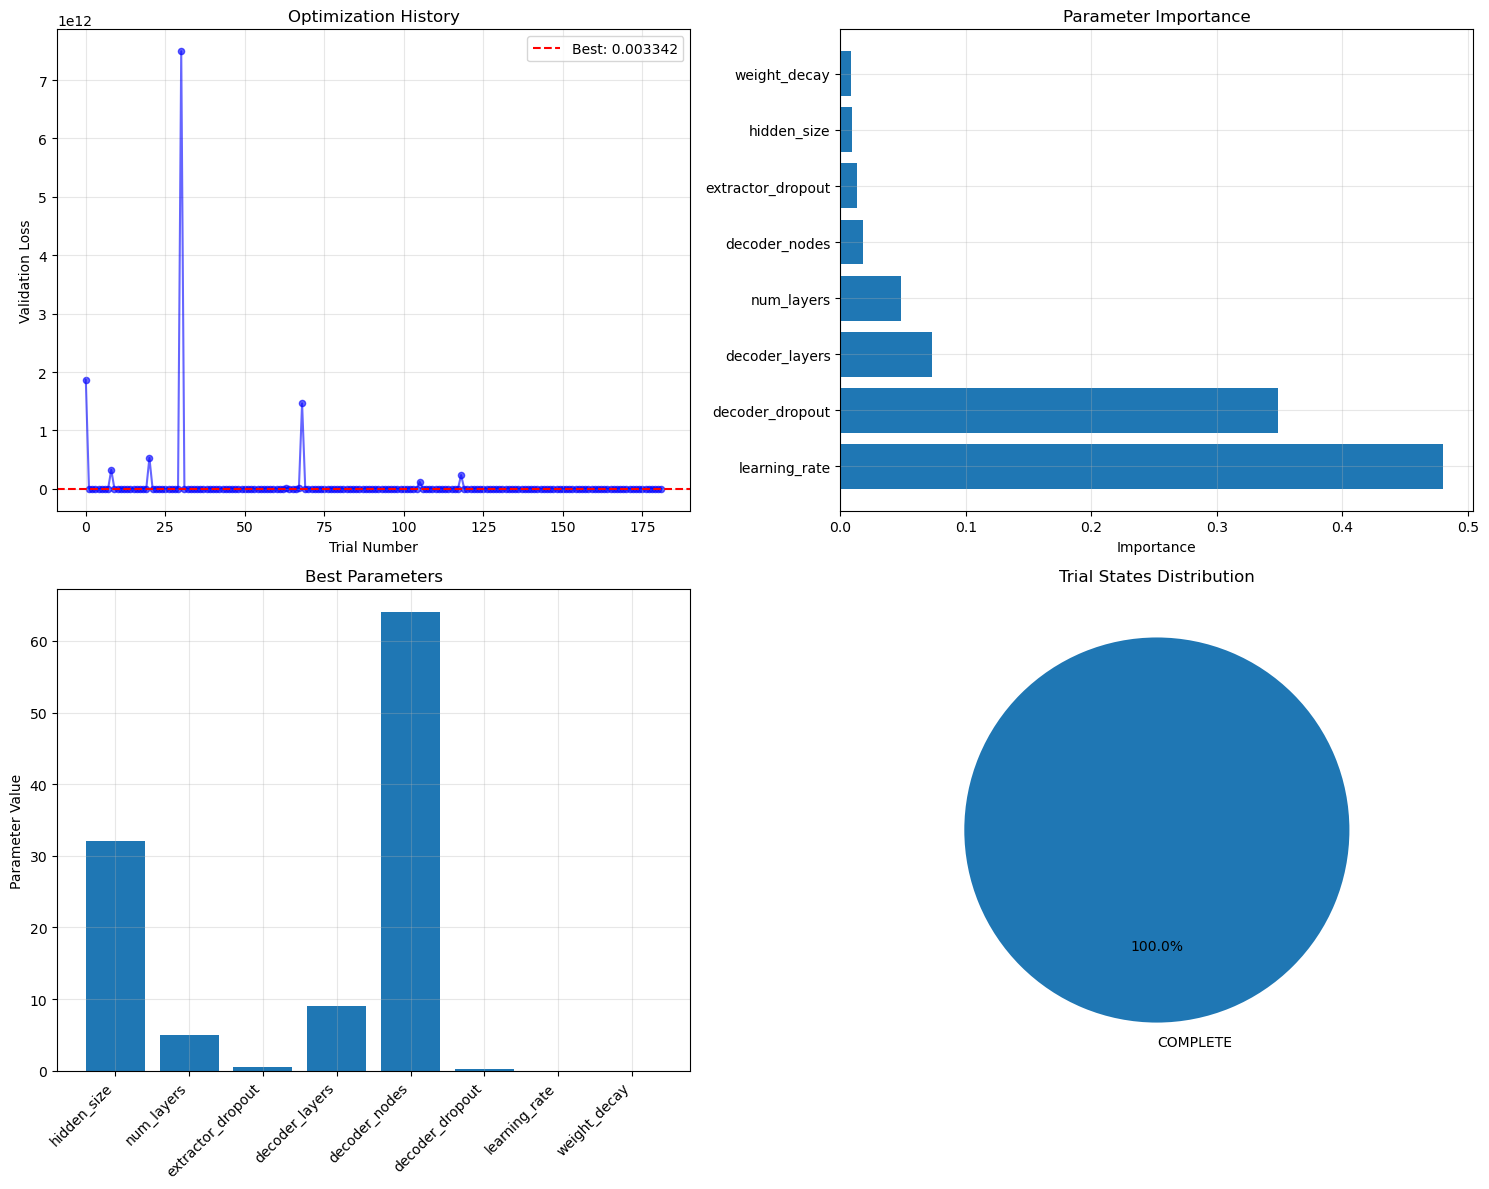


하이퍼파라미터 최적화 요약
총 실행된 trial 수: 182
성공한 trial 수: 182
Pruned trial 수: 0
실패한 trial 수: 0

최적의 검증 손실: 0.003342

최적 하이퍼파라미터:
  hidden_size: 32
  num_layers: 5
  extractor_dropout: 0.48869274761994175
  decoder_layers: 9
  decoder_nodes: 64
  decoder_dropout: 0.27176120230778256
  learning_rate: 0.0049560524197560475
  weight_decay: 2.2868619170568046e-05

상위 5개 trial:
  1. Trial 170: Loss = 0.003342
  2. Trial 172: Loss = 0.003344
  3. Trial 175: Loss = 0.003409
  4. Trial 54: Loss = 0.003411
  5. Trial 106: Loss = 0.003431


In [37]:
# Optuna 최적화 결과 시각화
import matplotlib.pyplot as plt
import numpy as np

# 1. 최적화 과정 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1-1. Optimization History
trials = study.trials
trial_values = [t.value for t in trials if t.value is not None]
trial_numbers = [t.number for t in trials if t.value is not None]

axes[0, 0].plot(trial_numbers, trial_values, 'b-', alpha=0.6)
axes[0, 0].scatter(trial_numbers, trial_values, c='blue', alpha=0.6, s=20)
axes[0, 0].axhline(y=study.best_value, color='red', linestyle='--', 
                   label=f'Best: {study.best_value:.6f}')
axes[0, 0].set_xlabel('Trial Number')
axes[0, 0].set_ylabel('Validation Loss')
axes[0, 0].set_title('Optimization History')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 1-2. Parameter Importance
try:
    importance = optuna.importance.get_param_importances(study)
    params = list(importance.keys())
    values = list(importance.values())
    
    axes[0, 1].barh(params, values)
    axes[0, 1].set_xlabel('Importance')
    axes[0, 1].set_title('Parameter Importance')
    axes[0, 1].grid(True, alpha=0.3)
except:
    axes[0, 1].text(0.5, 0.5, 'Parameter importance\nnot available', 
                    ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Parameter Importance')

# 1-3. Best Parameters Visualization
best_params = study.best_params
param_names = list(best_params.keys())
param_values = list(best_params.values())

# 숫자형 파라미터만 시각화
numeric_params = [(name, val) for name, val in best_params.items() if isinstance(val, (int, float))]
if numeric_params:
    names, vals = zip(*numeric_params)
    axes[1, 0].bar(range(len(names)), vals)
    axes[1, 0].set_xticks(range(len(names)))
    axes[1, 0].set_xticklabels(names, rotation=45, ha='right')
    axes[1, 0].set_ylabel('Parameter Value')
    axes[1, 0].set_title('Best Parameters')
    axes[1, 0].grid(True, alpha=0.3)

# 1-4. Trial States Distribution
states = [t.state.name for t in study.trials]
unique_states, counts = np.unique(states, return_counts=True)

axes[1, 1].pie(counts, labels=unique_states, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Trial States Distribution')

plt.tight_layout()
plt.show()

# 2. 최적화 전후 비교 (만약 이전 결과가 있다면)
print("\n" + "="*50)
print("하이퍼파라미터 최적화 요약")
print("="*50)
print(f"총 실행된 trial 수: {len(study.trials)}")
print(f"성공한 trial 수: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"Pruned trial 수: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
print(f"실패한 trial 수: {len([t for t in study.trials if t.state == optuna.trial.TrialState.FAIL])}")
print(f"\n최적의 검증 손실: {study.best_value:.6f}")
print("\n최적 하이퍼파라미터:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# 3. 상위 5개 trial 정보
print(f"\n상위 5개 trial:")
best_trials = sorted([t for t in study.trials if t.value is not None], 
                    key=lambda x: x.value)[:5]
for i, trial in enumerate(best_trials, 1):
    print(f"  {i}. Trial {trial.number}: Loss = {trial.value:.6f}")